In [9]:
%autosave 300

Autosaving every 300 seconds


In [10]:
# from Cleanser import get_data, convert_time
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist, pdist
from datetime import datetime
sns.set(color_codes=True)
# matplotlib.style.use("ggplot")
%matplotlib inline

In [11]:
# print(plt.style.available)
print(matplotlib.matplotlib_fname())

# font_location = "C:Windows/Fonts/NanumBarunGothic.ttf"
font_location = "/Users/RyuQae/Library/Fonts/NanumBarunGothic.otf"
# font_location = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

print(matplotlib.rcParams["font.family"])

/Users/RyuQae/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
['NanumBarunGothicOTF']


In [12]:
tidy_df = pd.read_pickle('output/tidy_df.pkl')

In [16]:
tidy_df.shape

(2153476, 18)

프라임타임 시간대(17시 이후부터) 1분 넘게 시청한 기록을 따로 분리하여 prime에 저장

In [ ]:
prime = tidy_df[(tidy_df.시청시작시간.dt.hour >= 17) & (tidy_df.프로그램시청시간 > 60)].copy()

In [ ]:
temp = prime.groupby(['기간', '일자', '요일', 'ID']).agg({'시청시작시간' : min, '시청종료시간' : max})

T2, T3, T4 전 기간에 걸쳐 패널로 등장하는 ID만을 대상으로 target_audience로 정의

In [ ]:
ids = tidy_df.groupby('기간').ID.apply(set).reset_index().set_index('기간')
target_audience = list(ids.ID[0] & ids.ID[1] & ids.ID[2])

개별 시청자의 17시 이후 첫 시청기록의 시작시간으로 프라임타임 진입시간대 정의하고, 그날 마지막 시청기록의 시청종료시간으로 이탈시간대 정의

In [ ]:
temp['진입시간대'] = temp.시청시작시간.dt.hour
temp['이탈시간대'] = temp.시청종료시간.dt.hour
temp.이탈시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)
temp.진입시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)

In [ ]:
agg1 = {
    '프로그램시청시간' : {
        '시청시간' : 'sum'
    }
}

=====================================================================

In [ ]:
pgenre_ratio = prime.groupby(['ID', '기간', '일자', '요일', '대분류'])\
    .agg({'프로그램시청시간':'sum'}).reset_index()

주중/주말을 나눠서 데이터프레임 저장

In [ ]:
weekday = ['Mon','Tue','Wed','Thu','Fri']
weekend = ['Sat', 'Sun']
wkday = pgenre_ratio[pgenre_ratio.요일.isin(weekday)].copy()
wkend = pgenre_ratio[pgenre_ratio.요일.isin(weekend)].copy()

In [ ]:
pvtd = pd.pivot_table(pgenre_ratio, 
                          values = '프로그램시청시간', 
                          index = ['기간', '일자', '요일', 'ID'], 
                          columns = '대분류').replace(np.nan, 0)

In [ ]:
vector = pvtd.join(temp[['진입시간대','이탈시간대']]).reset_index()
vector.head(10)

In [ ]:
wkday_v, wkend_v = vector[vector.요일.isin(weekday)], vector[vector.요일.isin(weekend)]

In [ ]:
wkday_v.head(10)

클러스터링의 input vector로 사용할 column은 아래와 같다.

In [ ]:
wkday_v.iloc[:,4:14].head(10)

우선 주중 장르별 시청시간에 대하여 각각 Standard Scaler와 MinMax Scaler로 Scale을 조정한다.

In [ ]:
wkday_std = StandardScaler().fit_transform(wkday_v.iloc[:,4:14])
wkday_Mm = MinMaxScaler().fit_transform(wkday_v.iloc[:,4:14])

## DBSCAN

In [ ]:
def do_dbscan(df, eps):
    start = datetime.now()
    db = DBSCAN(eps=eps).fit(df)
    print("Finished Learning: ",datetime.now() - start)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("The Number of Clusters: ", n_clusters_)
    
    major_groups = np.arange(-1, n_clusters_)[np.bincount(labels+1) > 500].tolist()
    print("Major Groups are ", major_groups)
    
    return labels, major_groups

두 가지 처리한 vector를 입력값으로 각각 DBSCAN 클러스터링

In [ ]:
std_labels, std_groups = do_dbscan(wkday_std, 0.08)

In [ ]:
mm_labels, mm_groups = do_dbscan(wkday_Mm, 0.02)

In [ ]:
wkday_v[std_labels == 21].head(20)

## K-Means

In [ ]:
def do_kmeans(df, k_range=range(2,30)):
    KMs = []
    Ls = []

    start = datetime.now()
    for n_clusters in k_range:
        print("k: ", n_clusters, "centroids")
        kmeans = KMeans(n_clusters=n_clusters).fit(df)
        labels = kmeans.labels_
        KMs.append(kmeans)
        Ls.append(labels)
    print("Finished Learning: ",datetime.now() - start)
    
    centroids = [k.cluster_centers_ for k in KMs]
    D_k = [cdist(df, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/df.shape[0] for d in dist]
    
    return KMs, Ls, centroids, avgWithinSS, cIdx

In [ ]:
# Run only one of either
kms, labs, cents, awss, cidx = do_kmeans(wkday_std)
# kms, labs, cents, awss, cidx = do_kmeans(wkday_Mm)

In [ ]:
# elbow curve

def elbow(awss, kIdx = 18, k_range=range(2,30)):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax.plot(k_range, awss, '*-')
    ax.plot(k_range[kIdx], awss[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='hotpink', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-means clustering')

In [ ]:
elbow(awss)

## PCA for Visualization

In [ ]:
pca = PCA(n_components=2)
projection = pd.DataFrame(pca.fit_transform(wkday_std))
projection.columns = ['first', 'second']
projection['group'] = labs[18]

# major = projection[projection.group.isin(major_groups)]

In [ ]:
projection.tail(10)

In [ ]:
sns.lmplot("second", "first", data=projection, fit_reg=False, size=8, markers='*')

In [ ]:
sns.lmplot("second", "first", data=projection, 
           fit_reg=False, size=8, hue="group", legend=True, markers='*')

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, )
fig.subplots_adjust(hspace=.5)

wkday_v[labs[18] == 3].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[0,0])
wkday_v[labs[18] == 6].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[0,1])
wkday_v[labs[18] == 11].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[1,0])
wkday_v[labs[18] == 14].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[1,1])
wkday_v[labs[18] == 15].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[2,0])
wkday_v[labs[18] == 18].describe().loc['mean']\
    .plot(kind='bar', figsize=(12,12), ax=axes[2,1])


# plt.ylim(0,10000)

In [ ]:
wkday_v[labs[18] == 3].describe()

## TVPro2Vec

In [27]:
from gensim.models import word2vec
import logging
from sklearn.manifold import TSNE
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO )

In [20]:
watched = tidy_df[tidy_df.프로그램시청시간 >= 600].copy()

In [21]:
daily_programs = watched.groupby(['ID','일자']).프로그램명.apply(list).tolist()
whole_programs = watched.groupby(['ID']).프로그램명.apply(list).tolist() 

In [22]:
len(daily_programs)
len(whole_programs)

4660

In [23]:
# model = gensim.models.Word2Vec(programs, min_count=1)
daily_model = word2vec.Word2Vec(daily_programs, size=300, window=10, min_count=5, workers=8)

2017-06-15 22:13:42,957 : INFO : collecting all words and their counts
2017-06-15 22:13:42,959 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-15 22:13:42,990 : INFO : PROGRESS: at sentence #10000, processed 91295 words, keeping 4250 word types
2017-06-15 22:13:43,037 : INFO : PROGRESS: at sentence #20000, processed 179628 words, keeping 5357 word types
2017-06-15 22:13:43,089 : INFO : PROGRESS: at sentence #30000, processed 261748 words, keeping 5906 word types
2017-06-15 22:13:43,157 : INFO : PROGRESS: at sentence #40000, processed 354513 words, keeping 6352 word types
2017-06-15 22:13:43,281 : INFO : PROGRESS: at sentence #50000, processed 443659 words, keeping 6654 word types
2017-06-15 22:13:43,342 : INFO : PROGRESS: at sentence #60000, processed 524999 words, keeping 6821 word types
2017-06-15 22:13:43,423 : INFO : PROGRESS: at sentence #70000, processed 605345 words, keeping 6973 word types
2017-06-15 22:13:43,484 : INFO : PROGRESS: at sentence

In [ ]:
model.most_similar(positive=['JTBC뉴스룸'], topn=20)

In [ ]:
model.most_similar(positive=['슈퍼맨이돌아왔다'], topn=20)

In [ ]:
model.most_similar(positive=['쓸쓸하고찬란하신도깨비'], topn=20)

In [24]:
model['쓸쓸하고찬란하신도깨비']

NameError: name 'model' is not defined

In [ ]:
whole_model = word2vec.Word2Vec(whole_programs, size=300, window=30, min_count=5, workers=8)

In [ ]:
whole_model.most_similar(positive=['가요무대'], topn=20)

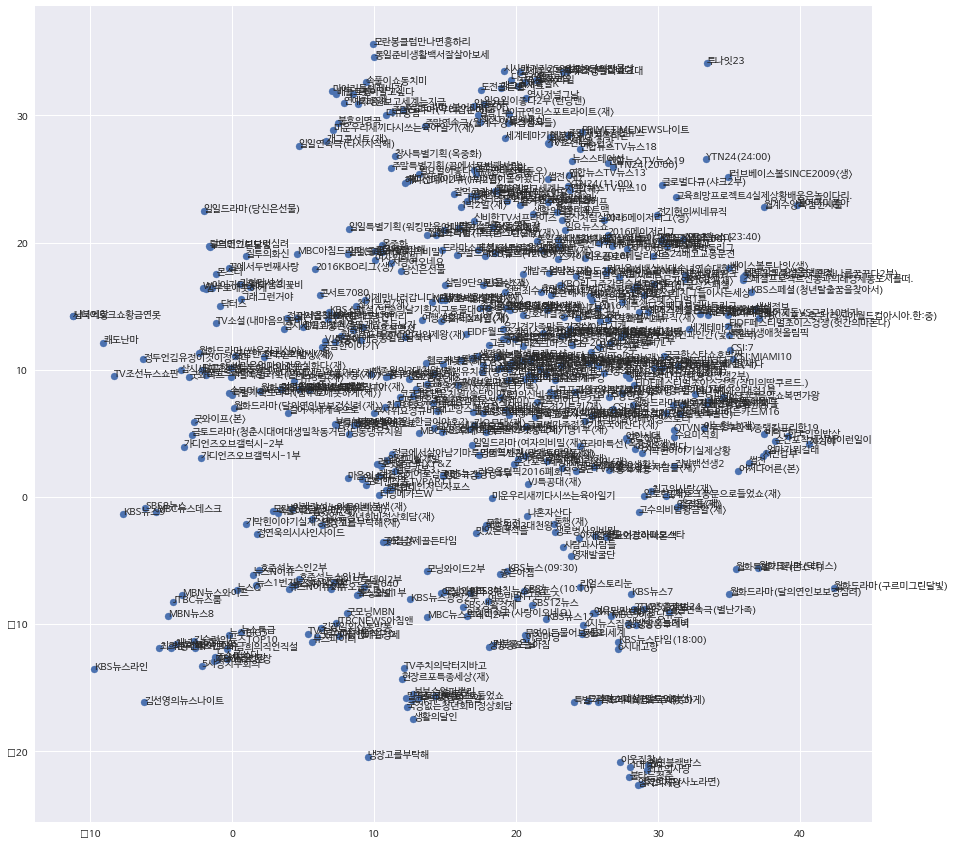

In [33]:
wv, vocabulary = daily_model[daily_model.wv.vocab], daily_model.wv.vocab

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(wv[0:500,:])

plt.figure(figsize=(15,15))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()